# Google maps distances

In [1]:
import utils
import numpy as np
import googlemaps
import time

api_key = open("googlemaps-apikey.txt", "r").read()
client = googlemaps.Client(key=api_key)

In [13]:
import importlib
importlib.reload(utils)

<module 'utils' from '/mnt/h/Documents/fifth_year_shit/math441/project/utils.py'>

Only take points that have addresses

58


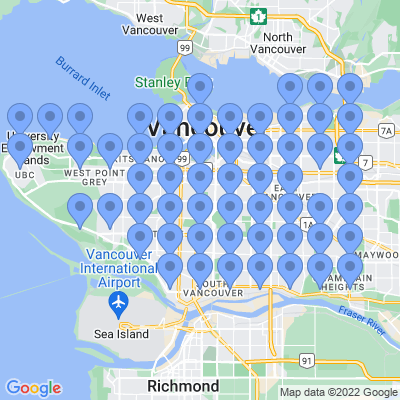

In [14]:
test_problem_center = (49.249828, -123.125774)
test_problem_top_left = (49.295863, -123.270310)
test_problem_bottom_right = (49.196127, -123.021401)
test_problem_points = utils.equidistant_points()
# print(len(test_problem_points))
# display(utils.get_map(test_problem_center, markers=[("blue", test_problem_points)], zoom=11))
# test_problem_points = list(filter(lambda p: utils.is_on_land(p), test_problem_points))
test_problem_points = list(filter(lambda p: utils.has_address_in(p), test_problem_points))
print(len(test_problem_points))
display(utils.get_map(test_problem_center, markers=[("blue", test_problem_points)], zoom=11))

Define set covering based on the real world google maps travel time

In [5]:
def make_set_covering_problem(positions):
    positions = [str(lat) + "," + str(long) for lat,long in positions]
    elems_per_min = 1000
    req_per_min = elems_per_min // len(positions)
    sleep_amt = int(60/req_per_min)
    print(f"Creating set covering matrix (n = {len(positions)}) (ratelimit sleep = {sleep_amt}s)")
    covering_matrix = np.array([])
    for start in positions:
        time.sleep(sleep_amt)
        # we can only have at most 25 destination, so we have to do this
        covered = []
        for slice_start_idx in range(0, len(positions), 25):
            # print(f"slice {slice_start_idx}, {slice_start_idx + 25}")
            # TODO: the covering matrix is symmetric, we can do half the number of elements requested from the api...
            destinations_slice = positions[slice_start_idx: slice_start_idx + 25]
            matrix = client.distance_matrix(origins=start, destinations=destinations_slice)
            times = [[elt["duration"]["value"] for elt in row["elements"]] for row in matrix["rows"]][0]
            covered.extend([1 if t < utils.NINE_MINS else 0 for t in times])
        assert(len(covered) == len(positions))
        covering_matrix = np.hstack((covering_matrix, covered))
    return covering_matrix.reshape(len(positions), len(positions))

    # the api restricts me to 100 elements per request, so this would fail on anything with more than 10 points
    # rip
    # matrix = client.distance_matrix(origins=positions, destinations=positions)
    # times = [[elt["duration"]["value"] for elt in row["elements"]] for row in matrix["rows"]]
    # covering_matrix = np.array([[1 if t < NINE_MINS else 0 for t in row] for row in times])
    # return covering_matrix.reshape(len(positions), len(positions))

In [15]:
solution = utils.set_covering_linprog_solver(test_problem_points, make_set_covering_problem(test_problem_points))

Creating set covering matrix (n = 58) (ratelimit sleep = 3s)


In [16]:
print(f"Locations used: {len(solution)}")

Locations used: 8


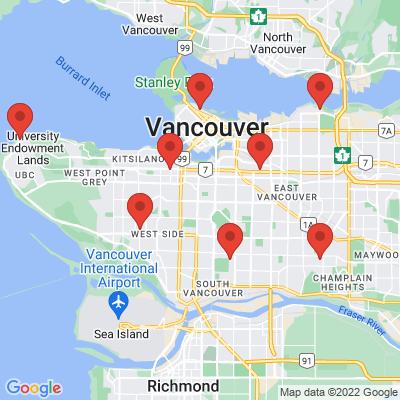

In [17]:
utils.display_solution(test_problem_center, test_problem_points, solution)

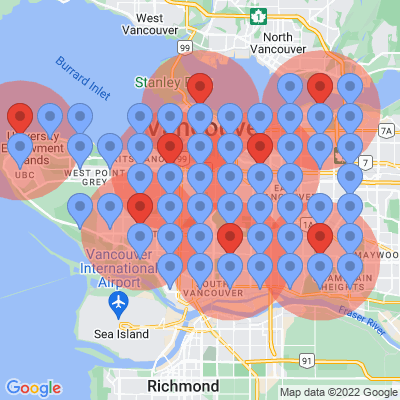

In [18]:
utils.display_solution(test_problem_center, test_problem_points, solution, show_problem_points=True, show_circular_coverage=True)

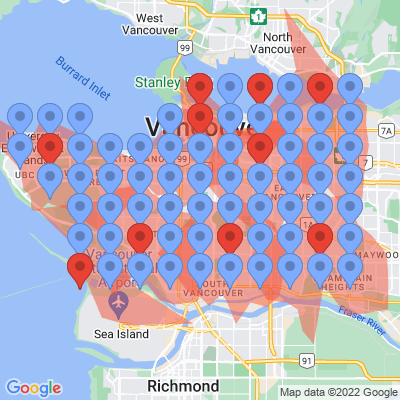

In [10]:
utils.display_solution(test_problem_center, test_problem_points, solution, show_problem_points=True,show_coverage=True)

In [19]:
hospitals = [test_problem_points[i] for i in solution]
uniform_eval = utils.uniform_random_evaluate_solution(hospitals)
population_eval = utils.population_sample_evaluate_solution(hospitals)
senior_eval = utils.senior_population_sample_evaluate_solution(hospitals)
balanced_eval = utils.balanced_sample_evaluate_solution(hospitals)
results = (uniform_eval, population_eval, senior_eval, balanced_eval)
print(f"model name => uniform sample, density sample, senior population sample, balanced sample")
print(f"google_maps_set_covering => {[round(r[0],3) for r in results]}")

model name => uniform sample, density sample, senior population sample, balanced sample
google_maps_set_covering => [2.021, 1.637, 1.641, 1.651]


In [23]:
maps_set_covering_solution = solution 
maps_set_covering_points = test_problem_points

In [24]:
%store maps_set_covering_solution
%store maps_set_covering_points

Stored 'maps_set_covering_solution' (list)
Stored 'maps_set_covering_points' (list)


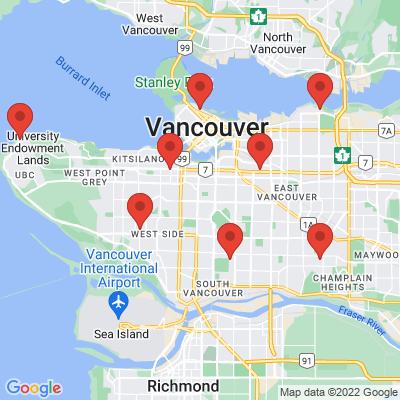

In [25]:
utils.display_solution(utils.vancouver_center, maps_set_covering_points, maps_set_covering_solution)